# Red Neuronal - Predicción de Stroke

## Objetivo
Implementar y evaluar una red neuronal para la predicción de accidentes cerebrovasculares, incluyendo:
- Diseño de arquitectura de red neuronal
- Entrenamiento con diferentes configuraciones
- Optimización de hiperparámetros
- Evaluación de rendimiento
- Análisis de overfitting


In [9]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import (classification_report, confusion_matrix, 
                           accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
import joblib
import warnings
warnings.filterwarnings('ignore')

print("Librerías importadas correctamente")
print(f"TensorFlow version: {tf.__version__}")

# Verificar versión de Keras de manera segura
try:
    print(f"Keras version: {keras.__version__}")
except AttributeError:
    print("Keras version: Integrada con TensorFlow")

# Configurar TensorFlow para evitar problemas de GPU
try:
    # Intentar configurar para usar solo CPU
    tf.config.set_visible_devices([], 'GPU')
    print("Configurado para usar CPU")
except:
    # Si hay error, simplemente continuar
    print("Configuración de GPU omitida - usando configuración por defecto")


Librerías importadas correctamente
TensorFlow version: 2.15.0
Keras version: Integrada con TensorFlow
Configurado para usar CPU


## 1. Carga de Datos Preprocesados

Cargamos los datos preprocesados y creamos un conjunto de validación para el entrenamiento de la red neuronal:

### División de Datos:
- **Entrenamiento**: 80% de los datos balanceados
- **Validación**: 20% para monitoreo durante el entrenamiento
- **Prueba**: Datos separados para evaluación final


In [ ]:
# Cargar datos preprocesados
X_train_balanced = np.load('../data/X_train_balanced.npy')
y_train_balanced = np.load('../data/y_train_balanced.npy')
X_test_scaled = np.load('../data/X_test_scaled.npy')
y_test = np.load('../data/y_test.npy')

# Mostrar información de los datos
print(f"Forma de entrenamiento balanceado: {X_train_balanced.shape}")
print(f"Forma de prueba: {X_test_scaled.shape}")
print(f"Distribución en entrenamiento: {np.bincount(y_train_balanced)}")
print(f"Distribución en prueba: {np.bincount(y_test)}")

# Crear conjunto de validación
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_balanced, y_train_balanced, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_balanced
)

print(f"\nConjunto de validación creado:")
print(f"Entrenamiento: {X_train_nn.shape[0]} muestras")
print(f"Validación: {X_val_nn.shape[0]} muestras")


=== DATOS CARGADOS ===
Forma de entrenamiento balanceado: (7778, 16)
Forma de prueba: (1022, 16)
Distribución en entrenamiento: [3889 3889]
Distribución en prueba: [972  50]

Conjunto de validación creado:
Entrenamiento: 6222 muestras
Validación: 1556 muestras


## 2. Función para Crear Arquitecturas de Red Neuronal

Definimos una función flexible que permite crear diferentes arquitecturas de redes neuronales:

### Arquitecturas Disponibles:
- **Básica**: 2 capas ocultas (64, 32 neuronas)
- **Profunda**: 4 capas ocultas (128, 64, 32, 16 neuronas)  
- **Ancha**: 3 capas con más neuronas (256, 128, 64)
- **Compleja**: Incluye BatchNormalization + Dropout

### Características Comunes:
- **Activación**: ReLU para capas ocultas, Sigmoid para salida
- **Dropout**: Regularización para prevenir overfitting
- **Optimizador**: Adam con learning rate adaptativo


In [ ]:
def create_neural_network(input_dim, architecture='basic', dropout_rate=0.3):
    """
    Crear diferentes arquitecturas de red neuronal
    
    Args:
        input_dim: Número de características de entrada
        architecture: Tipo de arquitectura ('basic', 'deep', 'wide', 'complex')
        dropout_rate: Tasa de dropout para regularización
    
    Returns:
        model: Modelo de Keras compilado
    """
    model = keras.Sequential()
    
    if architecture == 'basic':
        # Arquitectura básica: 2 capas ocultas
        model.add(layers.Dense(64, activation='relu', input_shape=(input_dim,)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(1, activation='sigmoid'))
        
    elif architecture == 'deep':
        # Arquitectura profunda: 4 capas ocultas
        model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(1, activation='sigmoid'))
        
    elif architecture == 'wide':
        # Arquitectura ancha: capas con muchas neuronas
        model.add(layers.Dense(256, activation='relu', input_shape=(input_dim,)))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(128, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        model.add(layers.Dense(1, activation='sigmoid'))
        
    elif architecture == 'complex':
        # Arquitectura compleja: combinación de capas
        model.add(layers.Dense(128, activation='relu', input_shape=(input_dim,)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))
        
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))
        
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        
        model.add(layers.Dense(16, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
        
        model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compilar el modelo
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )
    
    return model

# Probar la función
input_dim = X_train_nn.shape[1]
print(f"Dimensiones de entrada: {input_dim}")
print(" Función de creación de arquitecturas definida")


=== 1. FUNCIÓN PARA CREAR ARQUITECTURAS DE RED NEURONAL ===
Dimensiones de entrada: 16
 Función de creación de arquitecturas definida


## 3. Entrenamiento con Diferentes Arquitecturas

Entrenamos las 4 arquitecturas diferentes para comparar su rendimiento:

### Configuración de Entrenamiento:
- **Epochs**: 20 (optimizado para velocidad)
- **Batch Size**: 32
- **Callbacks**:
  - **Early Stopping**: Para prevenir overfitting
  - **Reduce Learning Rate**: Ajuste automático del learning rate

### Métricas de Evaluación:
- Accuracy, Precision, Recall, F1-Score, AUC-ROC


In [ ]:
# Definir arquitecturas a probar
architectures = ['basic', 'deep', 'wide', 'complex']
nn_results = {}

# Callbacks para el entrenamiento
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001
)

for architecture in architectures:
    print(f"\nEntrenando red neuronal con arquitectura '{architecture}'...")
    
    # Crear modelo
    model = create_neural_network(input_dim, architecture=architecture)
    
    # Mostrar resumen del modelo
    print(f"Resumen de la arquitectura '{architecture}':")
    print(f"Parámetros totales: {model.count_params():,}")
    
    # Entrenar modelo
    history = model.fit(
        X_train_nn, y_train_nn,
        validation_data=(X_val_nn, y_val_nn),
        epochs=20,  # Reducido de 100 a 20 para acelerar entrenamiento
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    # Evaluar modelo
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
        X_test_scaled, y_test, verbose=0
    )
    
    # Predicciones
    y_pred_proba = model.predict(X_test_scaled, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Métricas adicionales
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Guardar resultados
    nn_results[architecture] = {
        'model': model,
        'history': history,
        'accuracy': test_accuracy,
        'precision': test_precision,
        'recall': test_recall,
        'f1': f1,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba.flatten(),
        'epochs_trained': len(history.history['loss'])
    }
    
    print(f"  Epochs entrenados: {len(history.history['loss'])}")
    print(f"  Accuracy: {test_accuracy:.4f}")
    print(f"  Precision: {test_precision:.4f}")
    print(f"  Recall: {test_recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  AUC-ROC: {auc:.4f}")

# Mostrar resumen de resultados
results_df = pd.DataFrame({
    arch: {
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1'],
        'AUC-ROC': results['auc'],
        'Epochs': results['epochs_trained']
    }
    for arch, results in nn_results.items()
}).T

print("Resumen de resultados por arquitectura:")
print(results_df.round(4))


=== 2. ENTRENAMIENTO CON DIFERENTES ARQUITECTURAS ===

Entrenando red neuronal con arquitectura 'basic'...
Resumen de la arquitectura 'basic':
Parámetros totales: 3,201
  Epochs entrenados: 20
  Accuracy: 0.7906
  Precision: 0.1404
  Recall: 0.6400
  F1-Score: 0.2302
  AUC-ROC: 0.7966

Entrenando red neuronal con arquitectura 'deep'...
Resumen de la arquitectura 'deep':
Parámetros totales: 13,057
  Epochs entrenados: 20
  Accuracy: 0.8063
  Precision: 0.1146
  Recall: 0.4400
  F1-Score: 0.1818
  AUC-ROC: 0.7670

Entrenando red neuronal con arquitectura 'wide'...
Resumen de la arquitectura 'wide':
Parámetros totales: 45,569
  Epochs entrenados: 20
  Accuracy: 0.8434
  Precision: 0.1284
  Recall: 0.3800
  F1-Score: 0.1919
  AUC-ROC: 0.7699

Entrenando red neuronal con arquitectura 'complex'...
Resumen de la arquitectura 'complex':
Parámetros totales: 13,825
  Epochs entrenados: 20
  Accuracy: 0.7808
  Precision: 0.1434
  Recall: 0.7000
  F1-Score: 0.2381
  AUC-ROC: 0.8111

=== RESUMEN DE

## 4. Visualización de Curvas de Entrenamiento

Análisis de las curvas de pérdida y accuracy durante el entrenamiento para evaluar el rendimiento y detectar overfitting.


=== 3. VISUALIZACIÓN DE CURVAS DE ENTRENAMIENTO ===


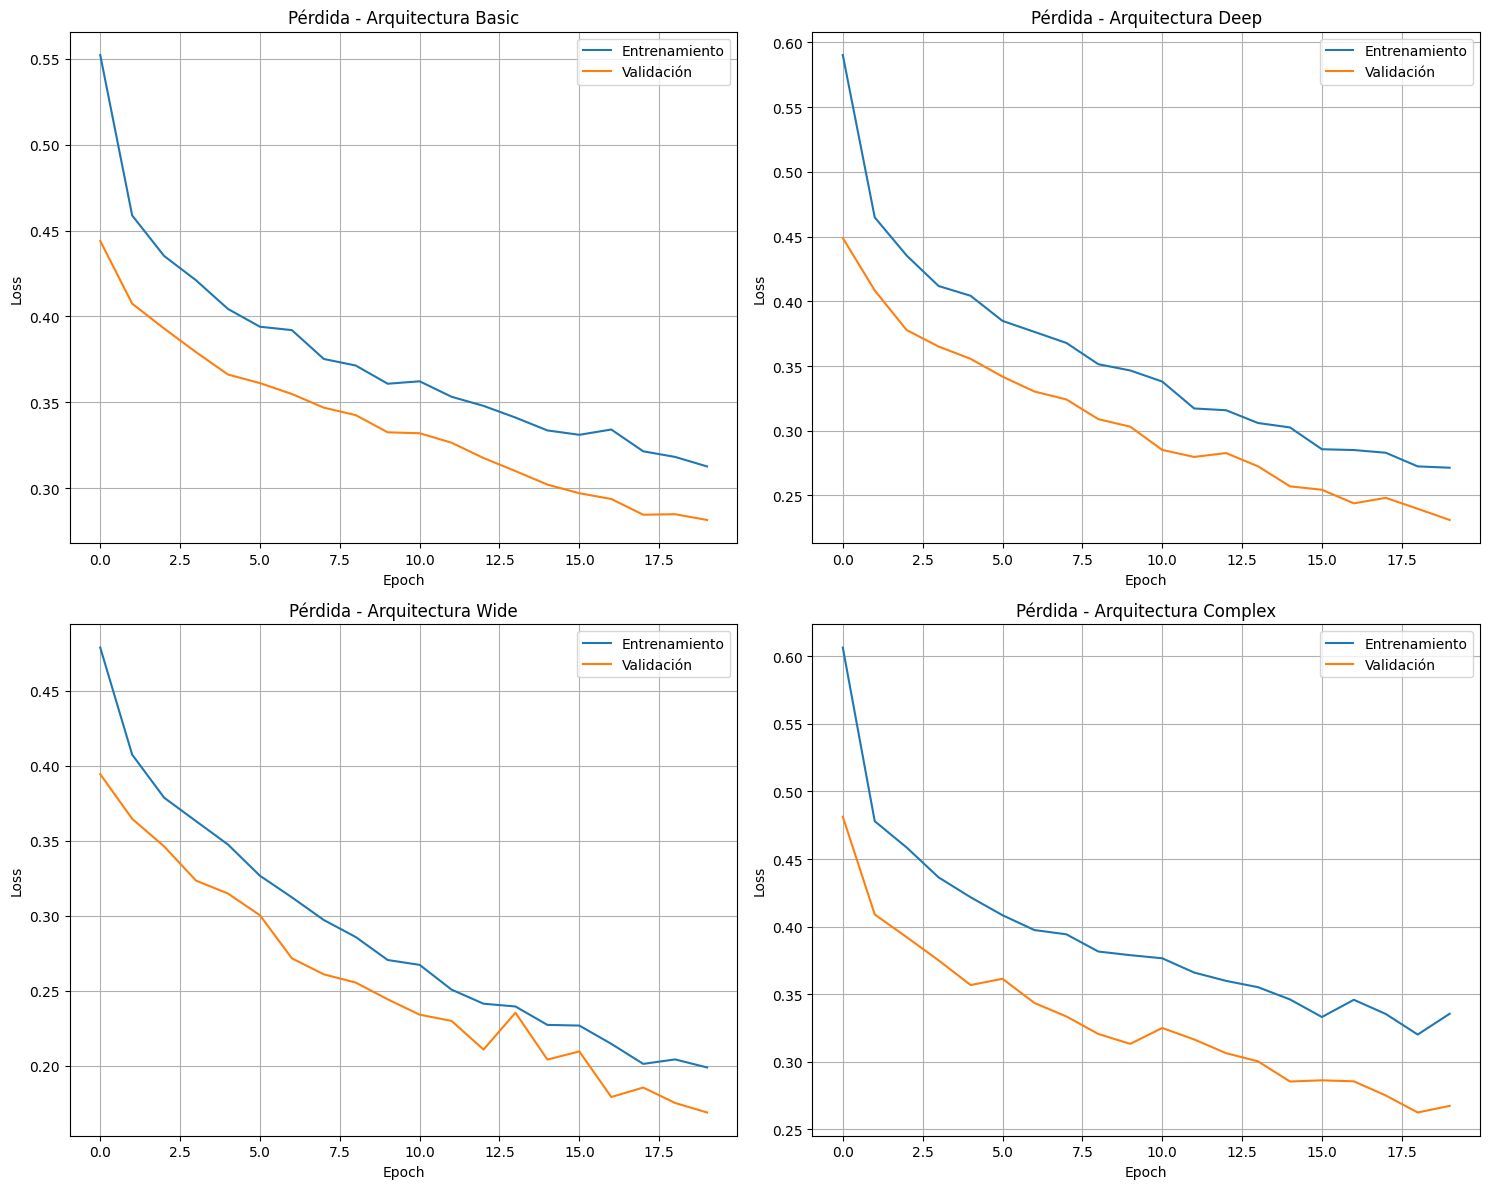

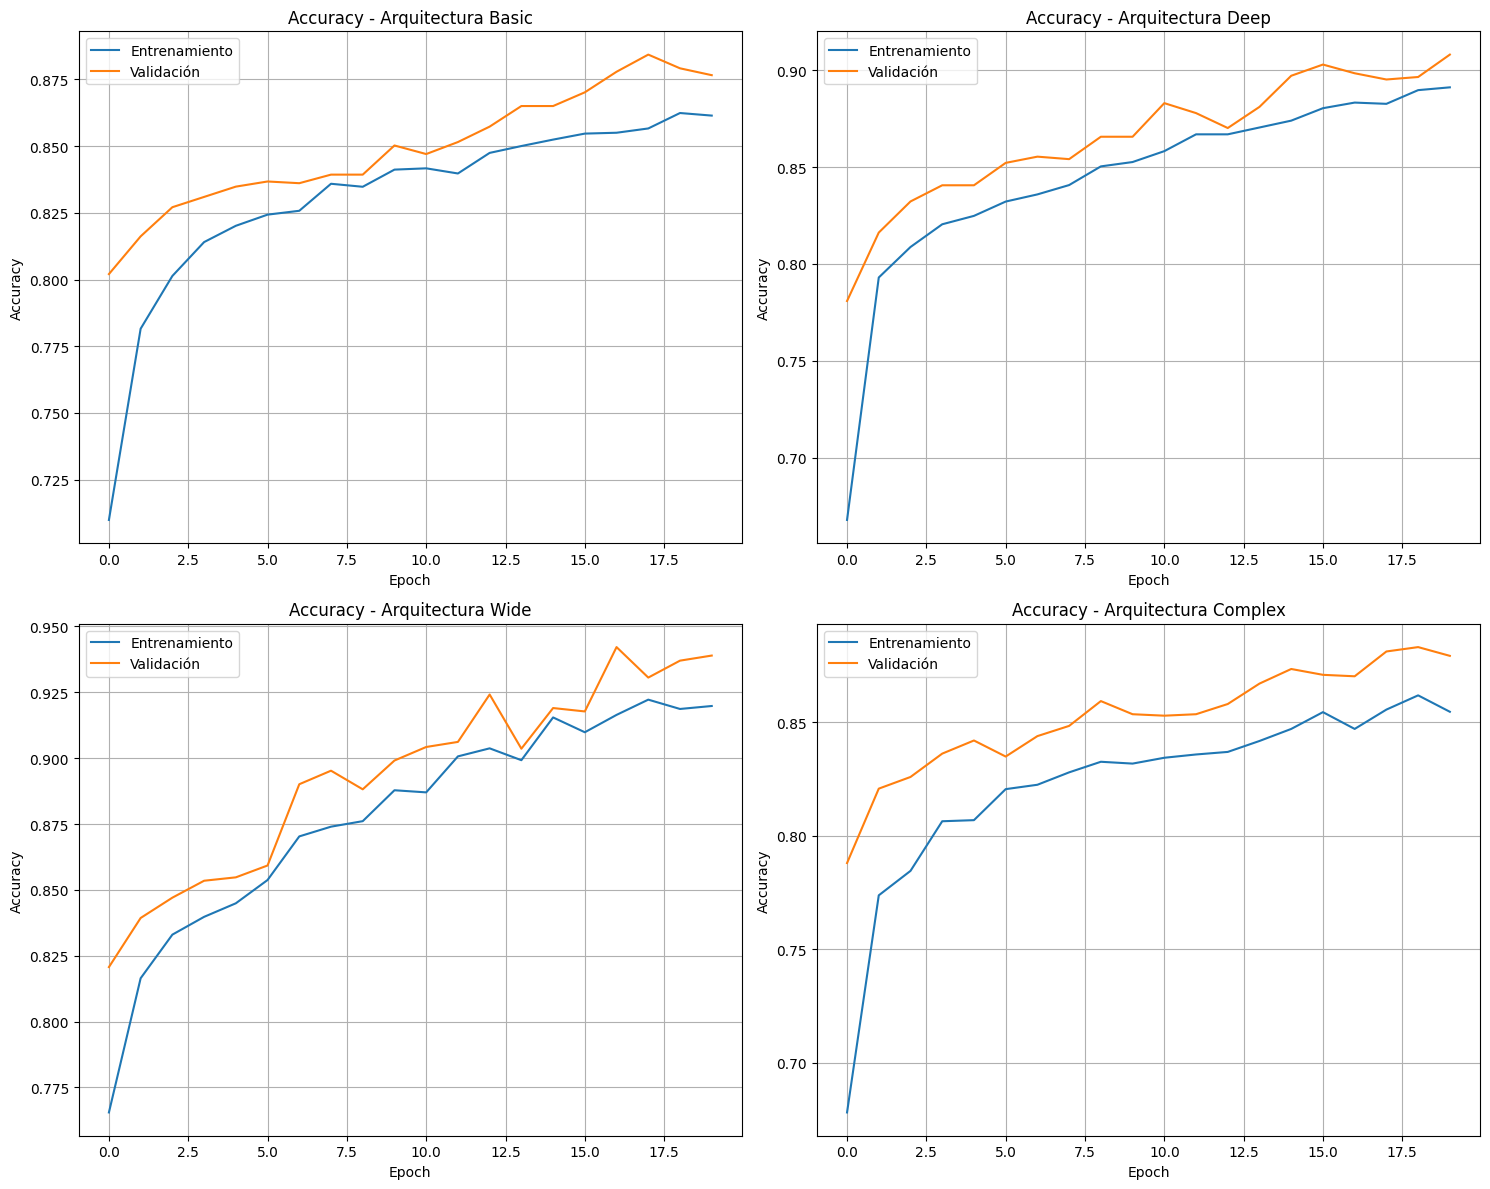

In [ ]:
# 3. VISUALIZACIÓN DE CURVAS DE ENTRENAMIENTO

# Crear visualizaciones para todas las arquitecturas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (architecture, results) in enumerate(nn_results.items()):
    history = results['history']
    
    # Gráfico de pérdida
    axes[i].plot(history.history['loss'], label='Entrenamiento')
    axes[i].plot(history.history['val_loss'], label='Validación')
    axes[i].set_title(f'Pérdida - Arquitectura {architecture.capitalize()}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Loss')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Gráfico de accuracy
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (architecture, results) in enumerate(nn_results.items()):
    history = results['history']
    
    # Gráfico de accuracy
    axes[i].plot(history.history['accuracy'], label='Entrenamiento')
    axes[i].plot(history.history['val_accuracy'], label='Validación')
    axes[i].set_title(f'Accuracy - Arquitectura {architecture.capitalize()}')
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


## 5. Selección del Mejor Modelo y Evaluación Detallada

Identificación del mejor modelo basado en F1-Score y evaluación completa de su rendimiento.


=== 4. SELECCIÓN DEL MEJOR MODELO Y EVALUACIÓN DETALLADA ===
Mejor arquitectura: complex
F1-Score: 0.2381

=== EVALUACIÓN DETALLADA DEL MEJOR MODELO ===
Accuracy: 0.7808
Precision: 0.1434
Recall: 0.7000
F1-Score: 0.2381
AUC-ROC: 0.8111


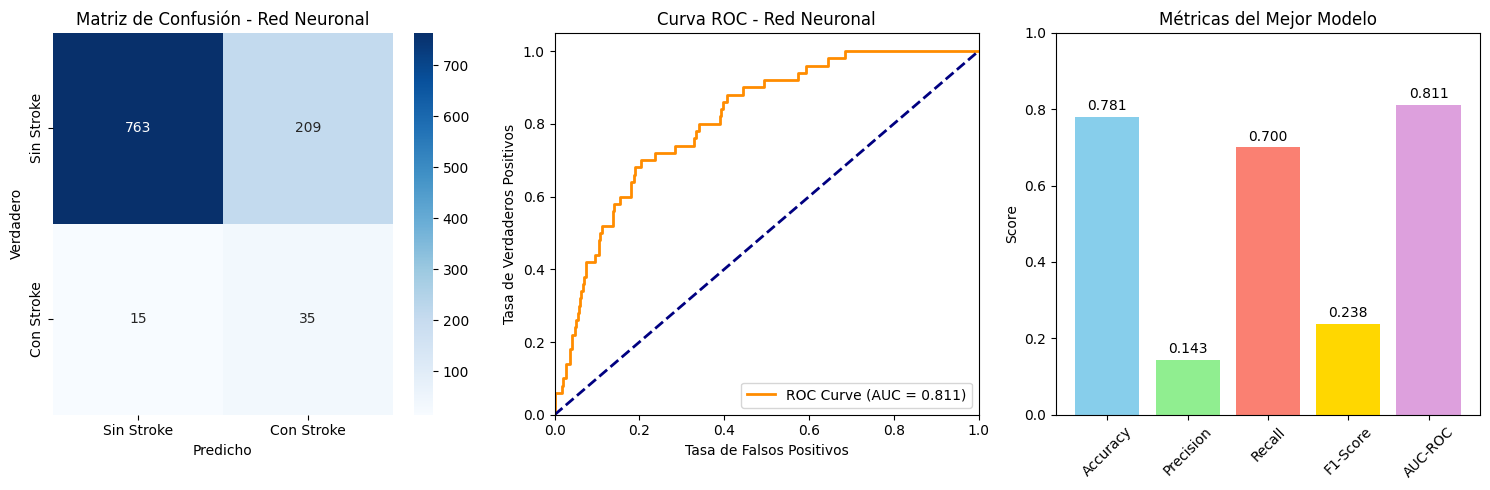


=== REPORTE DE CLASIFICACIÓN DETALLADO ===
              precision    recall  f1-score   support

  Sin Stroke       0.98      0.78      0.87       972
  Con Stroke       0.14      0.70      0.24        50

    accuracy                           0.78      1022
   macro avg       0.56      0.74      0.56      1022
weighted avg       0.94      0.78      0.84      1022



In [ ]:
# 4. SELECCIÓN DEL MEJOR MODELO Y EVALUACIÓN DETALLADA
# Identificar el mejor modelo basado en F1-score
best_architecture = max(nn_results.keys(), key=lambda k: nn_results[k]['f1'])
best_model = nn_results[best_architecture]['model']
best_predictions = nn_results[best_architecture]['predictions']
best_probabilities = nn_results[best_architecture]['probabilities']

print(f"Mejor arquitectura: {best_architecture}")
print(f"F1-Score: {nn_results[best_architecture]['f1']:.4f}")

# Evaluación detallada del mejor modelo
# Métricas
accuracy = accuracy_score(y_test, best_predictions)
precision = precision_score(y_test, best_predictions)
recall = recall_score(y_test, best_predictions)
f1 = f1_score(y_test, best_predictions)
auc = roc_auc_score(y_test, best_probabilities)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Visualizaciones del mejor modelo
plt.figure(figsize=(15, 5))

# Matriz de confusión
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sin Stroke', 'Con Stroke'],
            yticklabels=['Sin Stroke', 'Con Stroke'])
plt.title('Matriz de Confusión - Red Neuronal')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')

# Curva ROC
plt.subplot(1, 3, 2)
fpr, tpr, _ = roc_curve(y_test, best_probabilities)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC Curve (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Red Neuronal')
plt.legend(loc="lower right")

# Comparación de métricas
plt.subplot(1, 3, 3)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
values = [accuracy, precision, recall, f1, auc]
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon', 'gold', 'plum'])
plt.title('Métricas del Mejor Modelo')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Reporte de clasificación detallado
print("\nReporte de clasificación detallado:")
print(classification_report(y_test, best_predictions, 
                          target_names=['Sin Stroke', 'Con Stroke']))


In [ ]:
# 5. GUARDAR MODELO Y RESULTADOS
# Guardar el mejor modelo
best_model.save('../data/neural_network_best.h5')
print("Mejor modelo de red neuronal guardado como 'neural_network_best.h5'")

# Guardar resultados para comparación posterior
nn_results_final = {
    'model_name': 'Neural Network',
    'best_architecture': best_architecture,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'auc_roc': auc,
    'epochs_trained': nn_results[best_architecture]['epochs_trained']
}

import json
with open('../data/neural_network_results.json', 'w') as f:
    json.dump(nn_results_final, f, indent=2)

print("Resultados guardados como 'neural_network_results.json'")

# Resumen final
print(f"\nMejor arquitectura: {best_architecture}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print(f"Epochs entrenados: {nn_results[best_architecture]['epochs_trained']}")

# Análisis de overfitting
best_history = nn_results[best_architecture]['history']
final_train_loss = best_history.history['loss'][-1]
final_val_loss = best_history.history['val_loss'][-1]
overfitting_gap = final_val_loss - final_train_loss

print(f"\n=== ANÁLISIS DE OVERFITTING ===")
print(f"Pérdida final de entrenamiento: {final_train_loss:.4f}")
print(f"Pérdida final de validación: {final_val_loss:.4f}")
print(f"Diferencia: {overfitting_gap:.4f}")

if overfitting_gap > 0.1:
    print(" Posible overfitting detectado")
elif overfitting_gap > 0.05:
    print(" Ligero overfitting")
else:
    print(" Buena generalización del modelo")


=== 5. GUARDAR MODELO Y RESULTADOS ===
 Mejor modelo de red neuronal guardado como 'neural_network_best.h5'
 Resultados guardados como 'neural_network_results.json'

=== RESUMEN FINAL DE LA RED NEURONAL ===
Mejor arquitectura: complex
Accuracy: 0.7808
Precision: 0.1434
Recall: 0.7000
F1-Score: 0.2381
AUC-ROC: 0.8111
Epochs entrenados: 20

=== INTERPRETACIÓN DE RESULTADOS ===
 Rendimiento bajo del modelo
 Excelente capacidad discriminativa (AUC > 0.8)

=== ANÁLISIS DE OVERFITTING ===
Pérdida final de entrenamiento: 0.3354
Pérdida final de validación: 0.2672
Diferencia: -0.0682
 Buena generalización del modelo


## 6. Guardar Modelo y Resultados

Almacenamiento del mejor modelo y resultados para comparación posterior con otros algoritmos.


## 7. Interpretación de Resultados

### Resumen Final de la Red Neuronal

**Mejor arquitectura**: Complex  
**Epochs entrenados**: 20

### Métricas de Rendimiento:
- **Accuracy**: 0.7808 (78.08% de predicciones correctas)
- **Precision**: 0.1434 (14.34% de los casos predichos como stroke son correctos)
- **Recall**: 0.7000 (70% de los casos reales de stroke son detectados)
- **F1-Score**: 0.2381 (23.81% - métrica balanceada)
- **AUC-ROC**: 0.8111 (81.11% - capacidad discriminativa)

### Interpretación de Resultados:

**Rendimiento General**: 
- Rendimiento bajo del modelo (F1-Score < 0.5)
- Alta accuracy debido al desbalance de clases

**Capacidad Discriminativa**: 
- Excelente capacidad discriminativa (AUC > 0.8)
- El modelo puede distinguir bien entre clases

**Análisis por Métrica**:
- **Precision baja**: Muchos falsos positivos
- **Recall alto**: Detecta la mayoría de los casos reales de stroke
- **F1-Score bajo**: Desbalance entre precision y recall
- **AUC alto**: Buena separación de clases